In [4]:
import sys

sys.path.insert(0, "..")

import datetime
import time
from pathlib import Path
from typing import List, Tuple, Union

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from numpy.typing import NDArray
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.io import read_image, ImageReadMode
from torch.utils.data.sampler import Sampler
from torchvision.models import (
    EfficientNet_V2_S_Weights,
    MobileNet_V3_Large_Weights,
    MobileNet_V3_Small_Weights,
    ResNet50_Weights,
    efficientnet_v2_l,
    mobilenet_v3_large,
    mobilenet_v3_small,
    resnet50,
)
from torchvision.models.feature_extraction import create_feature_extractor
from torch.nn.functional import scaled_dot_product_attention
from torchvision.transforms import RandomCrop, Resize, transforms
from torchvision.transforms.functional import crop
from tqdm import tqdm
import pandas as pd
from model.model import MultiNetV2, BackboneType
import json
import math

torch.Size([5, 1, 32]), torch.Size([1, 5, 5])


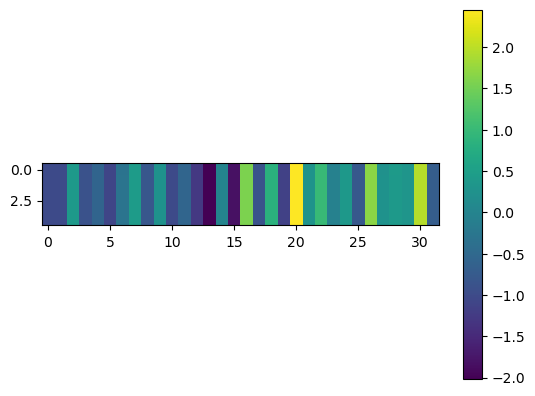

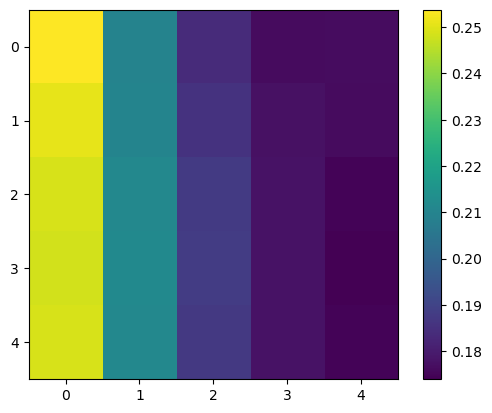

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_length: int, embedding_length: int):
        super().__init__()
        position = torch.arange(max_length).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embedding_length, 2)
            * (
                -torch.log(torch.tensor(10000.0, dtype=torch.float32))
                / embedding_length
            )
        )
        pe = torch.zeros(max_length, 1, embedding_length)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [sequence_length, batch_size, embedding_length]
        """
        return x + self.pe[: x.size(0)]


sequence_length = 5
embedding_length = 32
position_encoding = PositionalEncoding(sequence_length, embedding_length)
attention = torch.nn.MultiheadAttention(embed_dim=embedding_length, num_heads=1)
Q = nn.Linear(embedding_length, embedding_length)
K = nn.Linear(embedding_length, embedding_length)

x_input = torch.ones([sequence_length, 1, embedding_length])
x_input += position_encoding(x_input)
query = Q(x_input)
key = K(x_input)

output, weights = attention(
    query,
    key,
    x_input,
)
print(f"{output.shape}, {weights.shape}")

plt.imshow(output[:, 0, :].detach().numpy())
plt.colorbar()
plt.figure()
plt.imshow(weights[0].detach().numpy())
plt.colorbar()

In [15]:
query.transpose(0, 1).shape

torch.Size([1, 5, 32])

In [18]:
scaled_dot_product_attention(
    query=query.transpose(0, 1).unsqueeze(0).transpose(0, 1),
    key=key.transpose(0, 1).unsqueeze(0).transpose(0, 1),
    value=x_input,
)

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [5, 5] but got: [5, 1].

In [ ]:
outputs_1 = torch.matmul(weights, x_input.permute([1, 0, 2]))
plt.imshow(outputs_1.detach().numpy()[0])

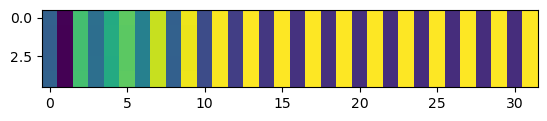

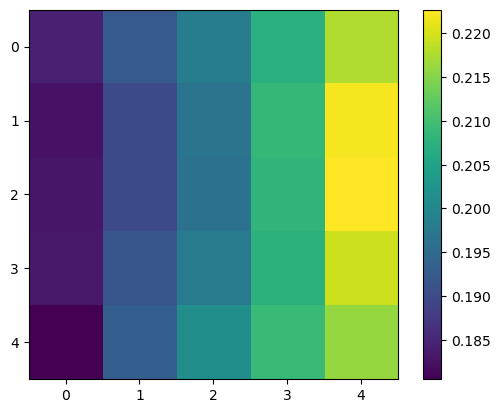

In [106]:
weights = torch.softmax(
    torch.matmul(query.permute([1, 0, 2]), key.permute([1, 0, 2]).transpose(1, 2))
    / 32**0.5,
    2,
)
outputs = torch.matmul(weights, x_input.permute([1, 0, 2]))

plt.figure()
plt.imshow(outputs[0].detach().numpy())

plt.figure()
plt.imshow(weights[0].detach().numpy())
plt.colorbar()

In [ ]:
# with torch.device('meta'):
#     model = MultiNetV2(numberClass=3, backboneType=BackboneType.RESNET50)

checkpoint = torch.load("../../data/model/26_model.pt")